In [164]:
import numpy as np
import pandas as pd
import torch

from torch.nn import functional as F
from annoy import AnnoyIndex
from requests_html import HTMLSession

from news_vec.encoder import read_preds
from news_vec.utils import read_json_gz_lines

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [2]:
UMAP_POINTS = pd.read_json('data/umap-points.json', lines=True)

In [16]:
def plot_umap(points, palette, title=None, dst=None):
    
    plt.figure(figsize=(7,6), dpi=100)
    plt.xlim(-8,8)
    plt.ylim(-7,6)

    sns.scatterplot(
        x='x',
        y='y',
        data=points,
        s=0.2,
        edgecolor=None,
        alpha=0.5,
        hue='outlet',
        palette=palette,
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if title:
        plt.title(title)
        
    if dst:
        plt.savefig(dst, bbox_inches='tight')

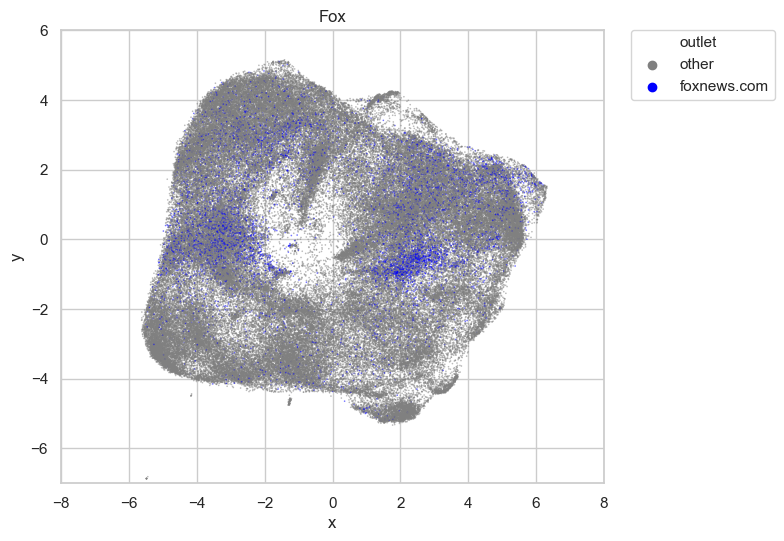

In [27]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d=='foxnews.com' else 'other')
palette = {'foxnews.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox')

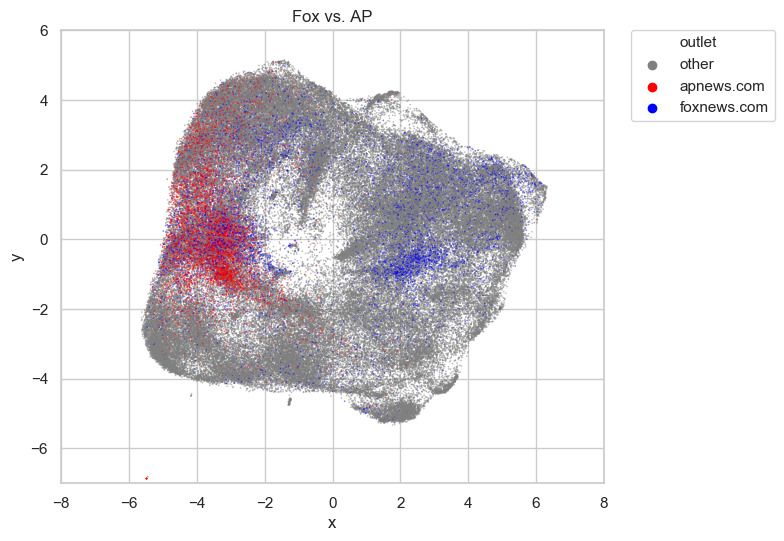

In [28]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d in ('apnews.com', 'foxnews.com') else 'other')
palette = {'apnews.com': 'red', 'foxnews.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox vs. AP')

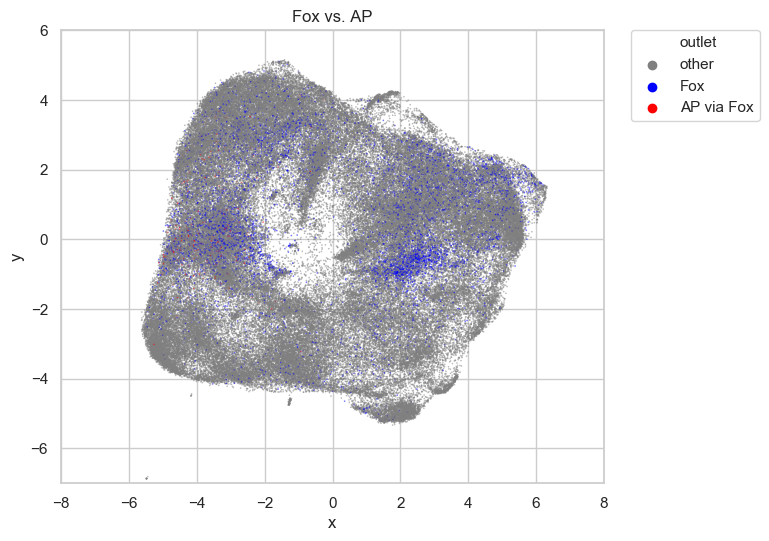

In [62]:
pdf = UMAP_POINTS.copy()
pdf['domains'] = pdf.domains.map(set)

def get_outlet(r):
    if r.domain == 'foxnews.com' and 'apnews.com' in r.domains:
        return 'AP via Fox'
    elif r.domain == 'foxnews.com':
        return 'Fox'
    else:
        return 'other'

pdf['outlet'] = pdf.apply(get_outlet, 1)

palette = {'AP via Fox': 'red', 'Fox': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox vs. AP')

# % of articles from AP

In [147]:
article_df = pd.DataFrame(read_json_gz_lines('../../data/clf-articles.json/'))

In [148]:
article_df['is_ap'] = article_df.domains.apply(lambda ds: 'apnews.com' in ds)

In [153]:
article_df[article_df.is_ap==True].groupby('domain').size() / article_df.groupby('domain').size()

domain
apnews.com            1.000000
bloomberg.com         0.008851
breitbart.com         0.009090
buzzfeed.com               NaN
cnn.com               0.000438
dailycaller.com       0.000126
dailykos.com          0.000083
foxnews.com           0.035745
huffingtonpost.com    0.000290
msnbc.com             0.000423
npr.org               0.000355
nytimes.com           0.010078
thehill.com           0.000461
washingtonpost.com    0.020717
wsj.com               0.001031
dtype: float64

# Nearby AP / Fox pairs

In [129]:
df, embeds = read_preds('../../data/ava-lstm-attn/')

100%|██████████| 284/284 [00:13<00:00, 30.39it/s]


In [130]:
df_train = df[df.split=='train']

In [131]:
def close_pairs(d1, d2, n_samples=1000000, n_pairs=20, plot=False):
    
    df1 = df_train[df_train.domain==d1]
    df2 = df_train[df_train.domain==d2]
    
    d1_embeds = embeds[df1.index]
    d2_embeds = embeds[df2.index]
    
    idx1 = np.random.choice(range(len(d1_embeds)), n_samples)
    idx2 = np.random.choice(range(len(d2_embeds)), n_samples)

    x1 = torch.from_numpy(d1_embeds[idx1])
    x2 = torch.from_numpy(d2_embeds[idx2])

    ds = F.cosine_similarity(x1, x2)
    ds = -(ds.numpy() - 1)
    
    if plot:
        sns.distplot(ds)
        plt.show()
    
    close_idxs = np.argsort(ds)[:n_pairs]
    
    for i1, i2 in zip(idx1[close_idxs], idx2[close_idxs]):
        line1 = ' '.join(df1.iloc[i1].clf_tokens)
        line2 = ' '.join(df2.iloc[i2].clf_tokens)
        print(f'{line1}\n{line2}\n')

In [132]:
close_pairs('apnews.com', 'foxnews.com')

martinez lowell boggs enjoy red sox alumni game at fenway
brewers drop series opening game to cubs in # innings

fugitive ex catalan leader held by police in germany
ethiopia sentences # accused al shabab members to prison

# dead # missing in alaska plane crash
# dead # injured in florida shooting

man rams vehicle into restaurant kills # injuries
army prototypes new self powering iron man soldier suits

austrian police detain suspect following vienna knife attack
israel arrests french consulate employee for gaza smuggling

# including boy dead in murder suicide amid custody battle
# teens charged as adults with fatally beating homeless man

ex tennessee teacher who fled with teen pleads guilty
missouri couple indicted in death of woman s teen daughter

bartolo colon designated for assignment by braves
packers rb ty montgomery hopes to play sunday vs cowboys

german woman dies raises death toll to # in spain attacks
egypt says # killed in attack outside cairo church

eu leaders to hol

# Fox articles close to AP mean

In [135]:
idx = AnnoyIndex(embeds.shape[1])

for r in df_train[df_train.domain=='foxnews.com'].itertuples():
    idx.add_item(r.Index, embeds[r.Index])
    
idx.build(20)

True

In [138]:
ap_mean = embeds[df_train[df_train.domain=='apnews.com'].index].mean(0)

In [158]:
fox_ap_nns = df_train.loc[idx.get_nns_by_vector(ap_mean, 500)]

In [154]:
urls_df = pd.DataFrame(read_json_gz_lines('../../data/article-urls.json/'))

In [159]:
fox_ap_nns = fox_ap_nns.merge(urls_df)

In [165]:
session = HTMLSession()

In [186]:
def scrape_dc_source(url):
    
    r = session.get(url)
    sources = r.html.xpath('//meta[@name="dc.source"]/@content')
    source = sources[0] if sources else None
    
    print(url, source)
    return source

In [ ]:
fox_ap_nns['dc_source'] = fox_ap_nns.url.apply(scrape_dc_source)

In [190]:
fox_ap_nns.groupby('dc_source').size()

dc_source
Associated Press    320
Fox News            118
Fox News Insider      3
FoxNews.com          10
FoxSports             7
LifeZette.com         1
LiveScience           1
Motor Authority       1
Newser                1
Reuters               1
SkyNews               1
Travel + Leisure      1
Warrior Maven         1
news.com.au           1
dtype: int64

In [197]:
fox_ap_nns.groupby('dc_source').size().sum()

467

In [198]:
118/467

0.25267665952890794

In [199]:
320/467

0.6852248394004282

# Hill <-> (DC / BB)

In [193]:
close_pairs('thehill.com', 'dailycaller.com')

dems up # points in party affiliation
cali dems approval numbers fall in latest poll

dems did nt do enough in kansas special election
cali dems approval numbers fall in latest poll

dem house campaign arm outraises republicans
dem strategist questions trump supporter s blackness

gingrich ingraham dems speaking out against franken a lynch mob
dem senator blames trump for dems shutting down the government

dems vow fight over obamacare benefits for women
dem rep warns party to stay away from impeachment

protesters chant no ban no wall outside supreme court after travel ban ruling
country music association bans media from asking about politics at cma awards

laura ingraham website incorrectly labels nba parade photo as trump supporters
rosie odonnell writes time tribute to roseanne barr and of course trump came up

dem compares believing in coal comeback to believing in easter bunny
dem rep refers to illegal immigrants as housekeepers and restaurant workers

clip of mccain defending ob

In [194]:
close_pairs('thehill.com', 'breitbart.com')

cnn s chris cuomo fake news label the equivalent of the n word for journalists
cnn s brian stelter fabricates conspiracy theory about fox news controlling trump

dem lawmaker calls trump a racial arsonist
dems boycott epa pick s confirmation hearing

cnn s chris cuomo fake news label the equivalent of the n word for journalists
cnn s smerconish trump could become the most consequential president in the modern era

dem rep calls for impeachment of trump
dems plan summer camps for trump resisters

bernie sanders calls for trump s disastrous immigration policy to be abolished
sean hannity calls media matters a clear and present danger to free speech

immigration hawk trump backs limited amnesty for illegal immigrants
trump s amnesty talk coincides with illegal border crossings surge

maxine waters on trump americans need to understand that something is terribly wrong
wallace to priebus on trump s press is the enemy tweet you do nt get to tell us what to do

valerie plame rips scooter libb